In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import ArmaProcess

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
ruta = r'/content/drive/MyDrive/Colab Notebooks/Series temporales/datasets/series_mensuales.xlsx'
columnas = ['Unnamed: 0','ipc' ,'ipener']
mensuales = pd.read_excel(ruta, sheet_name='Datos').loc[:, columnas]
mensuales.rename(columns= {'Unnamed: 0': 'fecha'}, inplace=True) 

ruta = r'/content/drive/MyDrive/Colab Notebooks/Series temporales/datasets/series_trimestrales.xlsx'
# PIB, % parados, total ocupados, ocupados en la construcción, coste trabajador construcción,
# precios vivienda, coste trab industrial
columnas = ['Unnamed: 0','pib', 'tasa paro', 'tno', 'poc', 'ctc', 'ipv', 'cti']
trimestrales = pd.read_excel(ruta, sheet_name='VARIABLES').loc[:, columnas]
trimestrales.rename(columns= {'Unnamed: 0': 'fecha'}, inplace=True) 

In [5]:
# Creamos una nueva variable con la ratio de ocupados en el sector construcción
trimestrales['ocup_constr_pct'] = trimestrales.poc.div(trimestrales.tno).mul(100)

# Convertirmos la columna fecha según ejemplo: tercer trimestre 1995 = 1995Q3 
trimestrales['fecha'] = trimestrales.fecha.str.replace('(', 'Q')
trimestrales['fecha'] = trimestrales.fecha.str.rstrip(')')

# podemos tratar la columna fecha como una fecha
trimestrales['fecha'] = pd.to_datetime(trimestrales.fecha)

# o como un periodo (trimestral = Quarterly)
#trimestrales['fecha'] = pd.PeriodIndex(trimestrales.fecha, freq='Q')

trimestrales.set_index('fecha', inplace=True)
trimestrales.dropna(how='all', inplace=True)

# datos mensuales
mensuales['fecha'] = pd.to_datetime(mensuales['fecha'])
mensuales.set_index('fecha', inplace=True)
mensuales.dropna(how='all', inplace=True)


# **Correlación entre dos series temporales**

Comparamos la evolución de los costes totales por trabajador para el sector industrial y el de la construcción.

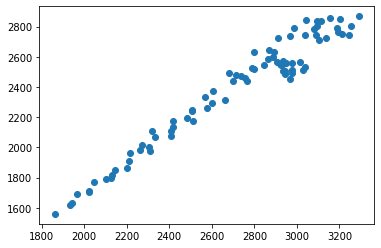

In [6]:
plt.scatter(x=trimestrales.cti, 
            y=trimestrales.ctc)

In [7]:
# Correlacion entre la ocupacion en la construcción y sus gastos por trabajador
corr_empleo_costeslaborales = (trimestrales.cti
                               .corr(
                                   trimestrales.ctc
                                   )
                               )
print("Correlación entre los costes totales de los trabajadores\n",
      "de los sectores industrial y constrrucción: ", 
      corr_empleo_costeslaborales)

Correlación entre los costes totales de los trabajadores
 de los sectores industrial y constrrucción:  0.9778761864747407


# **Autocorrelación**
evalúa la correlación entre una serie temporal y la misma serie desplazada en el tiempo (retrasada una unidad por defecto)

fecha
2002-01-01    74.585
2002-02-01    74.650
2002-03-01    75.267
2002-04-01    76.289
2002-05-01    76.563
Name: ipc, dtype: float64

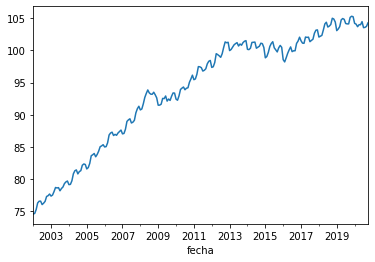

In [8]:
mensuales.ipc.plot()
mensuales.ipc.head()

In [9]:
# Inflación
cambio_mensual = mensuales.pct_change()
cambio_anual = mensuales.pct_change(12)

# Autocorrelaciones de los cambios temporales
autocorr_mensual = cambio_mensual['ipc'].autocorr()
print("La autocorrelación (1 retardo) del ipc mensual es %4.2f" %(autocorr_mensual))

autocorr_anual = cambio_anual['ipc'].autocorr()
print("La autocorrelación (12 retardos) del ipc mensual es %4.2f" %(autocorr_anual))

La autocorrelación (1 retardo) del ipc mensual es 0.23
La autocorrelación (12 retardos) del ipc mensual es 0.97


# **Función de Autocorrelación**



[ 1.          0.50609123  0.14089993  0.3263957   0.6306409   0.21602706
 -0.07773486  0.09544172  0.38355174  0.04980561 -0.16310881  0.05638875
  0.34684535  0.02147697 -0.24844665 -0.07431763  0.19631554 -0.12303755
 -0.34706804 -0.20141515  0.02034455 -0.25817213 -0.42359981 -0.26352642
 -0.02966153 -0.26689239 -0.41973382 -0.28220253 -0.04551332 -0.20292232
 -0.30166986 -0.15197206  0.03903022 -0.13529986 -0.19948922 -0.05938045
  0.08269861 -0.0855942  -0.1572221  -0.06111684  0.09759649]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


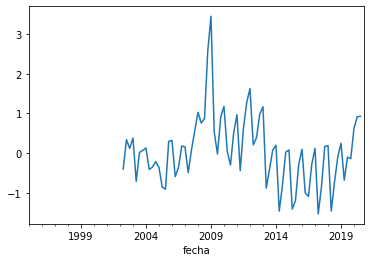

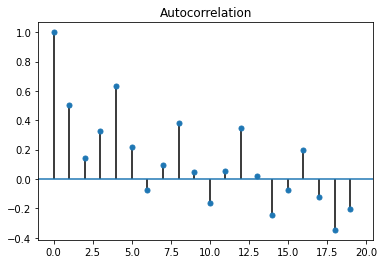

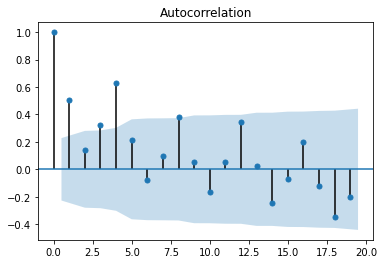

In [10]:
#serie en niveles: datos en bruto de la serie
#diferencia en puntos porcentuales (primeras diferencias)
acf_array = acf(trimestrales['tasa paro'].diff().dropna());
print(acf_array);

# Plot the acf function
trimestrales['tasa paro'].diff().plot();
plot_acf(trimestrales['tasa paro'].diff().dropna(), alpha=1);
plot_acf(trimestrales['tasa paro'].diff().dropna(), alpha=.05);

Concepto importante en relación a la autocorrelación y para utilizarse en los modelos posteriores:

## **Ruido Blanco**
Se caracteriza por:

*   Una media nula 
*   Una varianza constante
*   Una autocorrelación 0 en todos sus retardos (lags)



La media de la muestra es 0.019 y su desviación tipica 0.051 



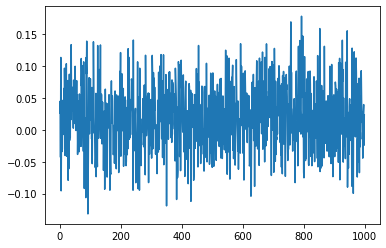

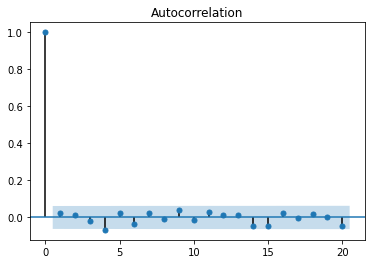

In [24]:
# Simulamos el ruido blando mediante una normal (5, .5)
epsilon = np.random.normal(loc=.02, scale=.05, size=1000)

# Comprobamos su media y desviación típica
media = np.mean(epsilon)
desv_tipica = np.std(epsilon)
print("La media de la muestra es %5.3f y su desviación tipica %5.3f \n" %(media, desv_tipica))

# Visualizamos la muestra de ruido blanco
plt.plot(epsilon)
plt.show()

# Analizamos su autocorrelación
plot_acf(epsilon, lags=20)
plt.show()

## **Paseos aleatorios**
En un paseo aleatorio el valor en un momento $t$  es igual al valor del momento $t-1$ más un valor aleatorio de ruido blanco:  
$$Y_{t}-Y_{t-1}=\epsilon_{t}$$
En ocasiones esta diferencia puede tener una media distinta de 0:  
$$Y_{t}-Y_{t-1}=\mu+\epsilon_{t}$$ 

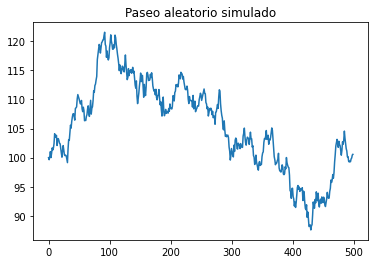

In [12]:
# Generamos valores de paso de un paseo aleatorio
pasos = np.random.normal(loc=0, scale=1, size=500)

# El primer paso lo fijamos en 0 para que el primer valor coincida con el introducido
pasos[0]=0

# Simulamos el paseo aleatorio fijando un valor inicial de 100
Y = 100 + np.cumsum(pasos)

# Visualizamos
plt.plot(Y)
plt.title("Paseo aleatorio simulado")
plt.show()

### Test de estadístico de Paseos aleatorios  
Para detectar si una serie temporal es un paseo aleatorio se analiza la ecuación:
$$Y_{t}=\alpha+\beta Y_{t-1}+\epsilon_{t}$$
Que es equivalente a:  
$$Y_{t}-Y_{t-1}=\alpha+\beta Y_{t-1}+\epsilon_{t}$$
En el que ponemos a prueba la hipótesis nula 
$$H_{0}: \beta=0\ (Paseo\ aleatorio)$$ 
Este test se conoce como Dickey-Fuller  

En primer lugar obtenemos la serie del ipc tratando de descontar la tendencia.  

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f73534b7ad0>,
      dtype=object)

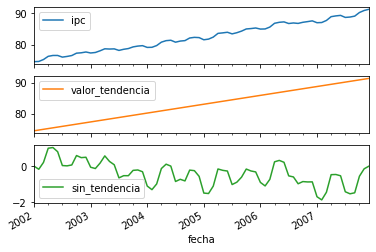

In [13]:
ipc = mensuales.loc['2002':'2007', ['ipc']]
tendencia = pd.DataFrame(
    np.linspace(start=ipc.iloc[0], 
                stop=ipc.iloc[-1], 
                num=ipc.shape[0]),
    columns=['valor_tendencia']).\
    set_index(ipc.index) 
ipc = pd.concat([ipc, tendencia], axis=1)
ipc['sin_tendencia'] = ipc['ipc'] - ipc['valor_tendencia']
ipc.plot(subplots=True)

Si elegimos un nivel de significación habitual del %5 esperamos un valor inferior a 0.05 para poder rechazar la hipótesis nula y afirmar que la serie no sigue un paseo aleatorio.  
En nuestro ejemplo no podemos rechazar la hipótesis y por lo tanto la serie del IPC en el periodo elegido sigue, probablemente un paseo aleatorio.

In [14]:
adf_test = adfuller(ipc['sin_tendencia'])
# podemos mostrar todos los resultados
print(adf_test)
# o directamente el p-valor :
print('\nEl p-valor del test es: ' + str(round(adf_test[1], 2)))

(-2.6582571931090535, 0.08154428826752835, 12, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, -7.803674299227964)

El p-valor del test es: 0.08


## **Series estacionarias**  
Una serie es estacionaria cuando:  

*   $\mathrm{E}(X_{t})=\mu$ para todo $t$
*   $\mathrm{Var}(X_{t})=\sigma^{2}$ para todo $t$
*   $\mathrm{Cov}(X_{t}, X_{t+k})=\gamma_{k}$, o lo que es lo mismo: es función del número de retardos y no del tiempo.

Por ejemplo, arriba hemos visto que el IPC entre 2002 y 2007 no era estacionario porque sigue una trayectoria ascendente (cambia la media). 
Cuando hemos descontado esa tendencia, queda una serie que parece seguir un paseo alatorio, que no tiene por qué ser estacionario. Sin embargo, podemos convertirlo en estacionario si aplicáramos las primeras diferencias. En $Y_t-Y_{t-1}$ sólo debería quedar ruido blanco.




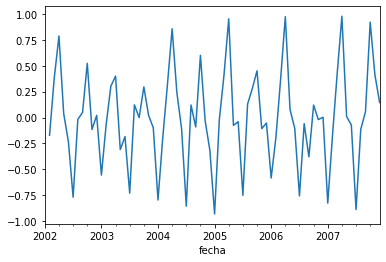

In [15]:
ipc['sin_tendencia'].diff().plot()

Para convertir una serie estacional en una serie estacionario habría que aplicar las diferencias de orden igual al periodo de dicha estacionalidad por ejemplo, el paro que tenemos en datos trimestrales habría que las cuartas diferencias

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f735bdf7510>,
      dtype=object)

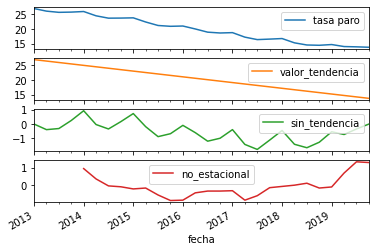

In [16]:
# limpiamos la serie
paro = trimestrales.loc['2013':'2019', ['tasa paro']].dropna()
# quitamos la tendencia
tendencia = pd.DataFrame(
    np.linspace(start=paro.iloc[0], 
                stop=paro.iloc[-1], 
                num=paro.shape[0]),
    columns=['valor_tendencia']).\
    set_index(paro.index) 
paro = pd.concat([paro, tendencia], axis=1)
paro['sin_tendencia'] = paro['tasa paro'] - paro['valor_tendencia']
# eliminamos la estacionalidad
paro['no_estacional'] = paro['sin_tendencia'].diff(4)
# Visualizamos el proceso
paro.plot(subplots=True)


para ver si se ha ido la estacionalidad podriamos visualizar de nuevo la Función de autocorrelación

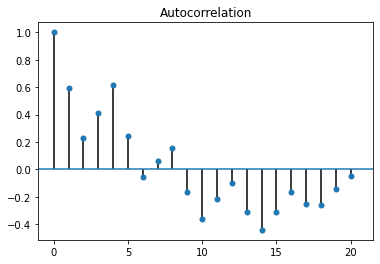

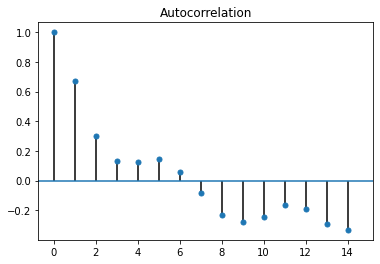

In [17]:
no_estacional = paro.loc[:, ['no_estacional']].dropna()
plot_acf(paro['sin_tendencia'], alpha=1, lags=20);
plot_acf(no_estacional, alpha=1);

Posiblemente quede algo de "señal" en el proceso porque...

# **Modelos autoregresivos**
Son de la forma $$Y_{t} = \mu+\phi Y_{t-1}+\epsilon_{t}$$  
Se aprecia que:
* si $\phi=1$ el proceso es un paseo aleatorio.
* si $\phi=0$ el proceso es ruido blanco
* si $-1\leqslant \phi\leqslant 1$ el proceso es estacionario.
* si $\phi\lt 0$ se trata de una regresión a la media
* si $\phi\gt 0$ se trata de un proceso de momento.


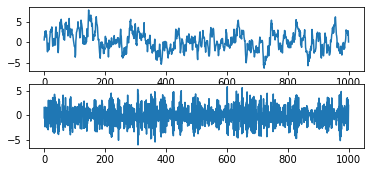

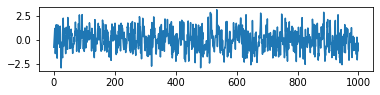

In [18]:
# simulamos proceso autoregresivo con tamaño muestral 1000 y phi=0.9 (cambio de signo por defecto)
plt.subplot(3,1,1)
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_1 = ArmaProcess(ar1, ma1)
simulacion_1 = AR_1.generate_sample(nsample=1000)
plt.plot(simulacion_1)

# simulamos phi=-0.9 (cambio de signo por defecto)
plt.subplot(3,1,2)
ar2 = np.array([1, 0.9])
ma2 = np.array([1])
AR_2 = ArmaProcess(ar2, ma2)
simulacion_2 = AR_2.generate_sample(nsample=1000)
plt.plot(simulacion_2)
plt.show()

# phi=0.3
plt.subplot(3,1,3)
ar2 = np.array([1, -0.3])
ma2 = np.array([1])
AR_3 = ArmaProcess(ar2, ma2)
simulacion_3 = AR_3.generate_sample(nsample=1000)
plt.plot(simulacion_3)
plt.show()

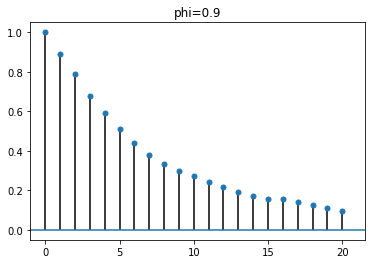

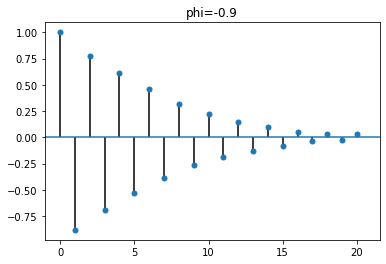

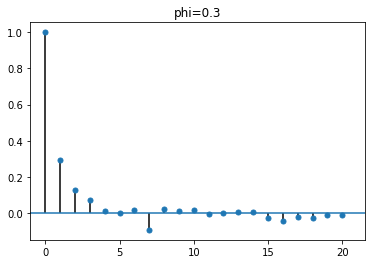

In [19]:
# ACF 1: phi=0.9
plot_acf(simulacion_1, alpha=1, lags=20, title='phi=0.9')
plt.show()

# ACF 2: phi = -0.9
plot_acf(simulacion_2, alpha=1, lags=20, title='phi=-0.9')
plt.show()

# ACF 3: phi = +0.3
plot_acf(simulacion_3, alpha=1, lags=20,title='phi=0.3')
plt.show()

Ahora tratamos de estimar los modelos que hemos simulado

In [20]:
mod_1 = ARMA(simulacion_1, order=(1, 0))
res_1 = mod_1.fit()

# Mostramos todos los resultados
print(res_1.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1451.724
Method:                       css-mle   S.D. of innovations              1.033
Date:                Wed, 05 Jan 2022   AIC                           2909.448
Time:                        15:10:14   BIC                           2924.171
Sample:                             0   HQIC                          2915.044
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3242      0.295      1.098      0.272      -0.254       0.903
ar.L1.y        0.8903      0.014     62.319      0.000       0.862       0.918
                                    Roots           

In [21]:
mod_2 = ARMA(simulacion_2, order=(1, 0))
res_2 = mod_2.fit()

# Imprimimos únicamente los parámetros estimados
print("Con una phi=0.9 real los parámetros mu y phi estimados son:")
print(res_2.params)

Con una phi=0.9 real los parámetros mu y phi estimados son:
[-0.03274892 -0.88070929]


Probamos con nuestra serie de paro sin tendencia ni estacionalidad
mod_paro = ARMA(

In [22]:
mod_paro = ARMA(no_estacional, order=(1, 0));
res_paro = mod_paro.fit();

# Imprimimos únicamente los parámetros estimados
print("Los parámetros mu y phi estimados son:")
print(res_paro.summary());

Los parámetros mu y phi estimados son:
                              ARMA Model Results                              
Dep. Variable:          no_estacional   No. Observations:                   24
Model:                     ARMA(1, 0)   Log Likelihood                  -7.992
Method:                       css-mle   S.D. of innovations              0.326
Date:                Wed, 05 Jan 2022   AIC                             21.984
Time:                        15:10:14   BIC                             25.518
Sample:                    01-01-2014   HQIC                            22.922
                         - 10-01-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.4439      0.568      0.781      0.443      -0.670       1.558
ar.L1.no_estacional     0.8988      0.087     10.273      0.000  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


Además de estimar podemos predecir

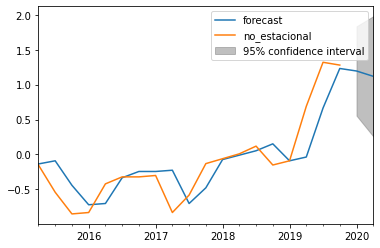

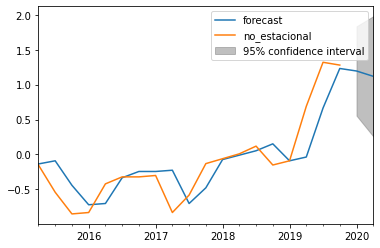

In [23]:
res_paro.plot_predict(start=5, end=25)